In [1]:
# data analysis
#18/05/21: stripped down version of IBM code for running locally on IBM Qsystem 1
import math
import certifi
# Importing standard Qiskit libraries and configuring account
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from scipy import stats

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer,BasicAer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity



In [2]:
#create folder name for saving in
from datetime import date
import os
import shutil
#date is used for file names later
today = date.today()
today=str(today)
#today=str('simulation')
#name of the quantum computer being used is the foldername and also used in the functions to select the computer
cname='ibmq_ehningen'
ii=complex(0,1)

0.008538028064292389
0.009203398361041126
0.009443904765906386
0.014042126392868256


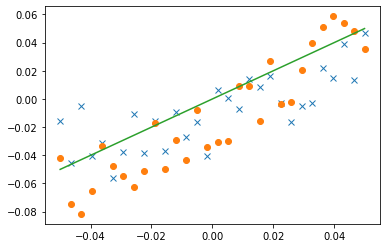

In [3]:
Fx = np.load(str(cname+str("_LR_2022_2Q_2")+str("/")+str("_2Q_est")+str('_EM_only')+str("/")+str("all_data")+str(".npz")),allow_pickle=True)
#print(Fx)
data_load=Fx['arr_0']

Fs = np.load(str(cname+str("_LR_2022_2Q_2")+str("/")+str("totshots")+str(".npz")),allow_pickle=True)
tot_shots=Fs['arr_0']
#print(data_load)

shotsEM=20000
shots_actual=5000


p=0.5
chiX1 = 2.606344146165026;
chiX2 = -1.254215457197949;
chiX3 =  0;
chiX4 = -1.254221981907920;

chiY1 = 0;
chiY2 = -2.858722304785182;
chiY3 = 0;
chiY4 = 2.858718037515484;

#first load the error mitigation
thvec=np.linspace(-0.05,0.05,30)



estxvec=[]
estyvec=[]

for jj in range(30):
    data_int=data_load[jj*8:8+jj*8]
    shots_int=tot_shots[jj*8:8+jj*8]
    
    #then load all the counts
    count00=0
    count01=0
    count10=0
    count11=0
    
    for kk in range(8):

        #need a vector with the appropriate number of each measurement outcome for this particular circuit
        #then we will discard a certain amount to only leave #shots_int[kk] in total
        n00=data_int[kk].get('00',0)
        n01=data_int[kk].get('01',0)
        n10=data_int[kk].get('10',0)
        n11=data_int[kk].get('11',0)

        #then make the vector

        data1=np.ones(shots_actual)
        data1[:int(n00)] = 0
        data1[int(n00):int(n00)+int(n01)] = 1
        data1[int(n00)+int(n01):int(n00)+int(n01)+int(n10)] = 2
        data1[int(n00)+int(n01)+int(n10):int(n00)+int(n01)+int(n10)+int(n11)] = 3
        np.random.shuffle(data1)
        #only want this much data
        dataint=data1[0:shots_int[kk]]

        count00=count00+np.count_nonzero(dataint==0)
        count01=count01+np.count_nonzero(dataint==1)
        count10=count10+np.count_nonzero(dataint==2)
        count11=count11+np.count_nonzero(dataint==3)

        countsint=np.count_nonzero(dataint==0)+np.count_nonzero(dataint==1)+np.count_nonzero(dataint==2)+np.count_nonzero(dataint==3)
        if countsint !=shots_int[kk]:
            print("\033[1;31;40m  Error, something not right with counts    ")

    n1=count00
    n2=count01
    n3=count10
    n4=count11


    estx=(chiX1*n1+chiX2*n2+chiX3*n3+chiX4*n4)*(1/shotsEM)
    esty=(chiY1*n1+chiY2*n2+chiY3*n3+chiY4*n4)*(1/shotsEM)


    estxvec.append(estx)
    estyvec.append(esty)

    

plt.plot(thvec,estxvec,'x')
plt.plot(thvec,estyvec,'o')
plt.plot(thvec,thvec)


res2QXalt = stats.linregress(np.array(estxvec),np.array(thvec))
res2QYalt = stats.linregress(np.array(estyvec),np.array(thvec))

print(res2QXalt.intercept)
print(np.mean(thvec-estxvec))


print(res2QYalt.intercept)
print(np.mean(thvec-estyvec))

intX=np.mean(thvec-estxvec)
intY=np.mean(thvec-estyvec)

# intX=res2QXalt.intercept
# intY=res2QYalt.intercept

intX=0
intY=0

In [9]:
#list of qubits you want to sample
qu1=0;
qu2=1;

#decoherence
p=0.5


#vector for storing all the circuits
tot_circs=[]
#vector for storing shot list
tot_shots=[]

shotsreal=4096


for mm in range(50):
#     for jj in range(10):
    #then run real estimation

    [circs_out,shots_out]=totcirc2Qnoise(0,shotsreal,qu1,qu2,p)

    for kk in range(len(circs_out)):
        tot_circs.append(circs_out[kk])
        tot_shots.append(shots_out[kk])

#then execute all at once
#job=execute(circs,qasm_sim,shots=shot_list)
Smax=np.max(tot_shots)
Smax=int(Smax)
print(Smax)

2304


In [10]:

np.savez(str(cname+str("_LR_2022_2Q_2")+str("/")+str("totshots2")), tot_shots)

0.014276860794600145
mse in x = 0.005361616936534913
mse in y = 0.008915243858065233

mean x value =  -0.027246265213843168
mean y value =  -0.026020004016678547


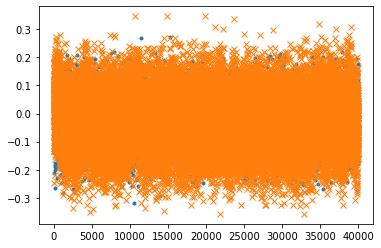

In [13]:
Fx = np.load(str(cname+str("_LR_2022_2Q_2")+str("/")+str("_2Q_est")+str("/")+str("all_data")+str(".npz")),allow_pickle=True)
#print(Fx)
data_load=Fx['arr_0']
Fs = np.load(str(cname+str("_LR_2022_2Q_2")+str("/")+str("totshots2")+str(".npz")),allow_pickle=True)
tot_shots=Fs['arr_0']
#print(data_load)
#print(len(data_load))

shotsEM=2000
shots_actual=2304
#
shotsrun=4096
shotsper=np.round(512)
p=0.5
chiX1 = 2.606344146165026;
chiX2 = -1.254215457197949;
chiX3 =  0;
chiX4 = -1.254221981907920;

chiY1 = 0;
chiY2 = -2.858722304785182;
chiY3 = 0;
chiY4 = 2.858718037515484;


estx_vec_512=[]
esty_vec_512=[]

mse_vec=[]
msex_vec=[]
msey_vec=[]

mse_vec_EM=[]
msex_vec_EM=[]
msey_vec_EM=[]

mse_vec_EM_512=[]
msex_vec_EM_512=[]
msey_vec_EM_512=[]


grouping=8
#50 repititions of the circuit

n00vec=[]
n01vec=[]
n10vec=[]
n11vec=[]


for hh in range(50):
    
    count00=0
    count01=0
    count10=0
    count11=0
    
    data_int=data_load[4*kk:4+4*kk]
    shots_int=tot_shots[4*kk:4+4*kk]
    
    for kk in range(4):
#         scaling_prob=shots_int[kk]/shotsrun
#         scaling_prob_vec.append(scaling_prob)

        n00=data_int[kk].get('00',0)
        n01=data_int[kk].get('01',0)
        n10=data_int[kk].get('10',0)
        n11=data_int[kk].get('11',0)
        
        #then make the vector
        
        data1=np.ones(shots_actual)
        data1[:int(n00)] = 0
        data1[int(n00):int(n00)+int(n01)] = 1
        data1[int(n00)+int(n01):int(n00)+int(n01)+int(n10)] = 2
        data1[int(n00)+int(n01)+int(n10):int(n00)+int(n01)+int(n10)+int(n11)] = 3
        np.random.shuffle(data1)
        #only want this much data
        dataint=data1[0:shots_int[kk]]
        
        count00=count00+np.count_nonzero(dataint==0)
        count01=count01+np.count_nonzero(dataint==1)
        count10=count10+np.count_nonzero(dataint==2)
        count11=count11+np.count_nonzero(dataint==3)
        
        countsint=np.count_nonzero(dataint==0)+np.count_nonzero(dataint==1)+np.count_nonzero(dataint==2)+np.count_nonzero(dataint==3)
        if countsint !=shots_int[kk]:
            print("\033[1;31;40m  Error, something not right with EM counts   ")
            
        if n00+n10+n01+n11 != shots_actual:
            print("\033[1;31;40m  Error, something not right with EM counts   ")

            
            
    totcounts=  count00+count01+count10+count11
    #now make a vector of all the data
    n00=count00
    n01=count01
    n10=count10
    n11=count11
    
    n00vec.append(n00)
    n01vec.append(n01)
    n10vec.append(n10)
    n11vec.append(n11)
    

    #THEN SUB GROUP with each of the 50 estimates
    if n00+n01+n10+n11 != shotsrun:
        print(n000+n010+n100+n110+n001+n011+n101+n111,shotsrun)
        print("\033[1;31;40m  Error, something not right with the counts from each estimate   ")
        
        
    for lll in range(100):
        shotsrunT=n00+n01+n10+n11

        data1=np.ones(shotsrunT)
        data1[:int(n00)] = 0
        data1[int(n00):int(n00)+int(n01)] = 1
        data1[int(n00)+int(n01):int(n00)+int(n01)+int(n10)] = 2
        data1[int(n00)+int(n01)+int(n10):int(n00)+int(n01)+int(n10)+int(n11)] = 3

        np.random.shuffle(data1)
        for hh in range(int(grouping)):
            dataint=data1[hh*shotsper:(hh+1)*shotsper]
            count00=np.count_nonzero(dataint==0)
            count01=np.count_nonzero(dataint==1)
            count10=np.count_nonzero(dataint==2)
            count11=np.count_nonzero(dataint==3)


            n1=count00
            n2=count01
            n3=count10
            n4=count11


            estx=(chiX1*n1+chiX2*n2+chiX3*n3+chiX4*n4)*(1/shotsper)
            esty=(chiY1*n1+chiY2*n2+chiY3*n3+chiY4*n4)*(1/shotsper)


            estx_vec_512.append(estx)
            esty_vec_512.append(esty)

            mse_vec_EM_512.append(estx**2+esty**2)
            msex_vec_EM_512.append((estx+intX)**2)
            msey_vec_EM_512.append((esty+intY)**2)

print(np.mean(mse_vec_EM_512))
print('mse in x =',np.mean(msex_vec_EM_512))

print('mse in y =',np.mean(msey_vec_EM_512))

plt.plot(estx_vec_512,'.')
plt.plot(esty_vec_512,'x')

print()
print('mean x value = ', np.mean(estx_vec_512) )

print('mean y value = ', np.mean(esty_vec_512) )

In [30]:
n00tot=np.sum(n00vec)
n01tot=np.sum(n01vec)
n10tot=np.sum(n10vec)
n11tot=np.sum(n11vec)
# print(n00tot+n01tot+n10tot+n11tot)
# print(4096*50)

totshots=n00tot+n01tot+n10tot+n11tot

p00=n00tot/totshots
p01=n01tot/totshots
p10=n10tot/totshots
p11=n11tot/totshots


MSEtot_x=[]
MSEtot_EM_x=[]
MSEtot_y=[]
MSEtot_EM_y=[]
nBootstrap=1000
for kk in range(nBootstrap):
    MSEint_x=[]
    MSE_EMint_x=[]
    MSEint_y=[]
    MSE_EMint_y=[]
    for jj in range(50*8):
        rv= np.random.multinomial(shotsper, [p00,p01,p10,p11], size=1)
        n1=rv[0][0]
        n2=rv[0][1]
        n3=rv[0][2]
        n4=rv[0][3]

        estx=(chiX1*n1+chiX2*n2+chiX3*n3+chiX4*n4)*(1/shotsper)
        esty=(chiY1*n1+chiY2*n2+chiY3*n3+chiY4*n4)*(1/shotsper)

        MSEint_x.append(estx**2)
        MSE_EMint_x.append((estx+intX)**2)
        MSEint_y.append(esty**2)
        MSE_EMint_y.append((esty+intY)**2)
        
    MSEtot_x.append(np.mean(MSEint_x))
    MSEtot_EM_x.append(np.mean(MSE_EMint_x))
    MSEtot_y.append(np.mean(MSEint_y))
    MSEtot_EM_y.append(np.mean(MSE_EMint_y))
    
print('MSE in x = ',np.mean(MSEtot_x),'+/-',np.std(MSEtot_x))
print('MSE in x with EM = ',np.mean(MSEtot_EM_x),'+/-',np.std(MSEtot_EM_x))
        
print('MSE in y = ',np.mean(MSEtot_y),'+/-',np.std(MSEtot_y))
print('MSE in y with EM = ',np.mean(MSEtot_EM_y),'+/-',np.std(MSEtot_EM_y))
    

MSE in x =  0.005972338543181868 +/- 0.0003980161313856494
MSE in x with EM =  0.005972338543181868 +/- 0.0003980161313856494
MSE in y =  0.009284737996109332 +/- 0.0006210513222366917
MSE in y with EM =  0.009284737996109332 +/- 0.0006210513222366917
